## Car Scratches detection by Mask R-CNN

## Performing prep
+ fetch model from s3
+ unzip mrcnn code

In [2]:
MODEL_FILE_NAME="mask_rcnn_scratch.h5"

In [11]:
%%bash
unzip -nq mrcnn.zip
mkdir -p logs output
aws s3 cp s3://cip.models/segmentation/scratch/latest/mask_rcnn_scratch.h5 logs/

Couldn't find program: 'bash'


In [4]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import skimage
# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model
import mrcnn.model as modellib
from mrcnn.model import log
import cv2
import car_scratch
import imgaug,h5py,IPython
import tensorflow as tf
from tensorflow.python.client import device_lib
from mrcnn.config import Config
from car_scratch import CustomConfig
from importlib import reload 
reload(visualize)
%matplotlib inline

Using TensorFlow backend.


In [5]:
DEVICE = "/cpu:0" 
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
gpu_list=get_available_gpus()
if len(gpu_list)>0:
    DEVICE="/gpu:0"
print("Choosing device ={}".format(DEVICE))

Choosing device =/cpu:0


### Configurations

In [27]:
class InferenceConfig(CustomConfig):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)   
MODEL_DIR = os.path.join(ROOT_DIR, "logs" )
MODEL_FILE_PATH=os.path.join(MODEL_DIR,MODEL_FILE_NAME)
DATA_DIR = os.path.join(ROOT_DIR, "custom")
IMAGE_TO_DETECT='data/test/multiple_scratches.png'
OUT_BB_PREFIX='output/bb__'
OUT_SPLASH_PREFIX='output/splash__'


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Loading Model w/ last weights

In [19]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,  config=config)

print("Latest checkpoint weights file path:{}".format(MODEL_FILE_PATH))
model.load_weights(MODEL_FILE_PATH, by_name=True) 

Latest checkpoint weights file path:C:\Users\ameet.chaubal\Documents\source\CIP\image_segmentation\logs\mask_rcnn_scratch.h5


### Detection on a single image by passing image path.

In [24]:
image_name=os.path.basename(IMAGE_TO_DETECT)
image = skimage.io.imread(IMAGE_TO_DETECT)
r = model.detect([image], verbose=1)[0]
print('Detecting image:{}\nThe car Label:{} # of classes {} damages'.
      format(image_name, r['class_ids'], len(r['class_ids'])))

Processing 1 images
image                    shape: (350, 590, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Detecting image:multiple_scratches.png
The car Label:[1 1 1] # of classes 3 damages


### Display Instances

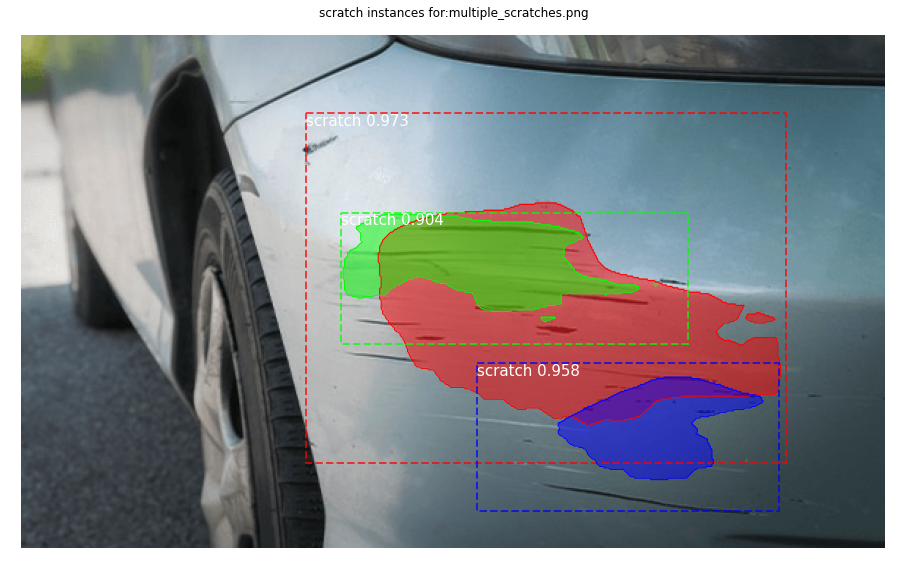

In [28]:
# Display results
ax = get_ax(1)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['BG','scratch', ], r['scores'], ax=ax,
                            title="scratch instances for:"+image_name,
                           filename=OUT_BB_PREFIX +image_name)

In [ ]:
pix_cnt = r['masks'].sum()
h,w = r['masks'].shape[0:2]
a = pix_cnt/(w*h)
print ("Image size: w={} h={} mask PIxels:{} area={}".format(w,h, pix_cnt,a))
 

HT_CAR_IN = 18
LEN_CAR_IN = 14
h_in_per_pix = HT_CAR_IN/h
w_in_per_pix = LEN_CAR_IN/w
single_pix_area =h_in_per_pix*w_in_per_pix
print("Single pix area:{}".format(h_in_per_pix*w_in_per_pix))
print("Total area:{}".format(single_pix_area*pix_cnt))

### Color Splash

Shapes: mask=(350, 590, 1) image=(350, 590, 3) gray=(350, 590, 3)


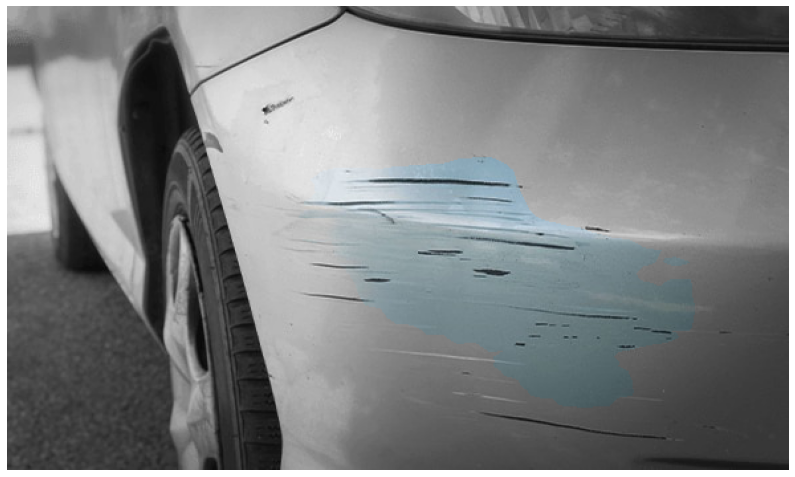

In [29]:
splash = car_scratch.color_splash(image, r['masks'])
display_images([splash], cols=1, filename=OUT_SPLASH_PREFIX+image_name)


### Detection of image from `validation` dataset by choosing a random image

In [ ]:
dataset = custom_1.CustomDataset()
dataset.load_custom(DATA_DIR,'val')
dataset.prepare()
print('Images: {}\nclasses: {}'.format(len(dataset.image_ids), dataset.class_names))

#### Visualize model weight matrix descriptive statistics(shapes, histograms)  

In [ ]:
visualize.display_weight_stats(model)

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print('The car has:{} damages'.format(len(dataset.image_info[image_id]['polygons'])))